Explanatory Data Analysis and Feature Engineering

/tmp/ipykernel_37/836336540.py:11: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Shape after dropping nulls: (383564, 2)
Shape after mapping to 4 categories: (210353, 3)


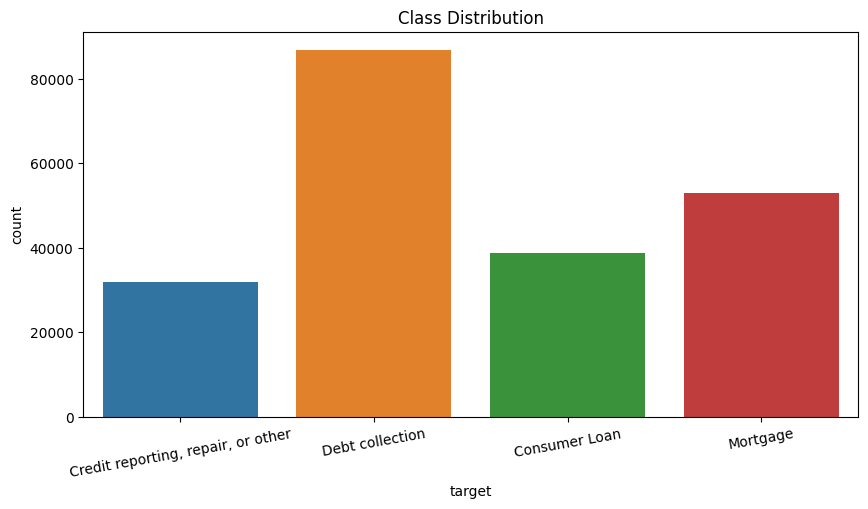


Class distribution:
target
1    0.412212
3    0.251896
2    0.184338
0    0.151555
Name: proportion, dtype: float64


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1.1: Load Data
# Use the correct file path from your Kaggle environment
file_path = '/kaggle/input/consumer-complaint-database/rows.csv'

# Load the data (use nrows=200000 for faster testing if needed)
# df = pd.read_csv(file_path, nrows=200000)
df = pd.read_csv(file_path)

# 1.2: Select relevant columns and drop nulls
# We only need the complaint text and the product
df = df[['Product', 'Consumer complaint narrative']]
# Drop any rows where the complaint text is missing
df = df.dropna(subset=['Consumer complaint narrative']).copy()

print(f"Shape after dropping nulls: {df.shape}")

# 1.3: Feature Engineering - Map Products to Target Categories
# Define the mapping from the dataset's 'Product' to your 4 categories
category_map = {
    # Category 0: Credit reporting, repair, or other
    'Credit reporting': 0,
    'Credit repair services': 0,
    'Other financial service': 0,
    
    # Category 1: Debt collection
    'Debt collection': 1,
    
    # Category 2: Consumer Loan
    'Consumer Loan': 2,
    'Student loan': 2,
    'Payday loan': 2,
    'Vehicle loan or lease': 2,
    
    # Category 3: Mortgage
    'Mortgage': 3,
    'Home equity loan or line of credit': 3
}

# Create the new 'target' column based on the map
df['target'] = df['Product'].map(category_map)

# 1.4: Clean Data
# Drop rows that didn't map to any of our 4 categories
df = df.dropna(subset=['target']).copy()
# Convert target to integer
df['target'] = df['target'].astype(int)

print(f"Shape after mapping to 4 categories: {df.shape}")

# 1.5: EDA - Check Class Distribution
# Create a dictionary for easy-to-read labels
target_names = {
    0: 'Credit reporting, repair, or other',
    1: 'Debt collection',
    2: 'Consumer Loan',
    3: 'Mortgage'
}

plt.figure(figsize=(10, 5))
sns.countplot(x=df['target'])
plt.title('Class Distribution')
plt.xticks(ticks=[0, 1, 2, 3], labels=[target_names[i] for i in range(4)], rotation=10)
plt.show()

# Show the percentage breakdown
print("\nClass distribution:")
print(df['target'].value_counts(normalize=True))

Text Pre-Processing

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data (run this in a cell once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. Lowercase and remove punctuation/numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A).lower()
    
    # 2. Tokenize (split text into words)
    tokens = word_tokenize(text)
    
    # 3. Remove stopwords and lemmatize
    # We also remove very short words (len <= 2)
    processed_tokens = [
        lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words and len(word) > 2
    ]
    
    # 4. Join words back into a single string
    return ' '.join(processed_tokens)

# Apply the preprocessing to our complaint column
# This is the most time-consuming step!
# On the full dataset, this can take 20-40 minutes.
print("Starting text preprocessing...")
df['cleaned_narrative'] = df['Consumer complaint narrative'].apply(preprocess_text)
print("Text preprocessing finished.")

# Display a before-and-after example
print("\n--- Preprocessing Example ---")
print("Original:", df['Consumer complaint narrative'].iloc[0])
print("\nCleaned:", df['cleaned_narrative'].iloc[0])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Starting text preprocessing...
Text preprocessing finished.

--- Preprocessing Example ---
Original: i never received anything stating that i owed this company money. My first time seeing this is when i pulled my credit report. Never got a notice in the mail nothing.

Cleaned: never received anything stating owed company money first time seeing pulled credit report never got notice mail nothing


Selection of Multi Classification model# 

In [10]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Define the common TF-IDF Vectorizer settings
# We'll use the same vectorizer for all models to ensure a fair comparison
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# 3.1: Create a dictionary of pipelines
models_to_compare = {
    "Naive Bayes": Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('clf', MultinomialNB())
    ]),
    
    "Logistic Regression": Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('clf', LogisticRegression(solver='saga', max_iter=1000, random_state=42, n_jobs=-1))
    ]),
    
    "Linear SVM (SVC)": Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('clf', LinearSVC(random_state=42, max_iter=2000)) # LinearSVC is fast
    ]),
    
    "Random Forest": Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)) # n_jobs=-1 uses all cores
    ])
}

Comparison of model performance

In [11]:
from sklearn.metrics import f1_score
import time

model_scores = {}
trained_models = {}

print("--- Starting Model Training and Comparison ---")

for name, model in models_to_compare.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    preds = model.predict(X_test)
    
    # Calculate weighted F1-score
    f1 = f1_score(y_test, preds, average='weighted')
    
    # Store results
    model_scores[name] = f1
    trained_models[name] = model  # Store the fitted model
    
    end_time = time.time()
    print(f"{name} trained in {end_time - start_time:.2f} seconds")
    print(f"{name} Weighted F1-Score: {f1:.4f}")

    # WARNING: Random Forest will be *significantly* slower than the others.
    # On the full dataset, it could take over an hour.

# 4.1: Find the best model
print("\n--- Model Comparison Summary ---")
for name, score in model_scores.items():
    print(f"{name}: {score:.4f}")

best_model_name = max(model_scores, key=model_scores.get)
best_model_score = model_scores[best_model_name]
best_model_pipeline = trained_models[best_model_name] # This is our winning, trained model

print(f"\n--- Best Model ---")
print(f"Model: {best_model_name}")
print(f"Weighted F1-Score: {best_model_score:.4f}")

--- Starting Model Training and Comparison ---

Training Naive Bayes...
Naive Bayes trained in 58.46 seconds
Naive Bayes Weighted F1-Score: 0.8746

Training Logistic Regression...
Logistic Regression trained in 67.31 seconds
Logistic Regression Weighted F1-Score: 0.9039

Training Linear SVM (SVC)...
Linear SVM (SVC) trained in 67.57 seconds
Linear SVM (SVC) Weighted F1-Score: 0.9013

Training Random Forest...
Random Forest trained in 590.09 seconds
Random Forest Weighted F1-Score: 0.9018

--- Model Comparison Summary ---
Naive Bayes: 0.8746
Logistic Regression: 0.9039
Linear SVM (SVC): 0.9013
Random Forest: 0.9018

--- Best Model ---
Model: Logistic Regression
Weighted F1-Score: 0.9039


Model Evaluation


--- Classification Report (Logistic Regression) ---
                                    precision    recall  f1-score   support

Credit reporting, repair, or other       0.88      0.83      0.86      6376
                   Debt collection       0.89      0.93      0.91     17342
                     Consumer Loan       0.88      0.85      0.87      7755
                          Mortgage       0.95      0.95      0.95     10598

                          accuracy                           0.90     42071
                         macro avg       0.90      0.89      0.90     42071
                      weighted avg       0.90      0.90      0.90     42071


--- Confusion Matrix (Logistic Regression) ---


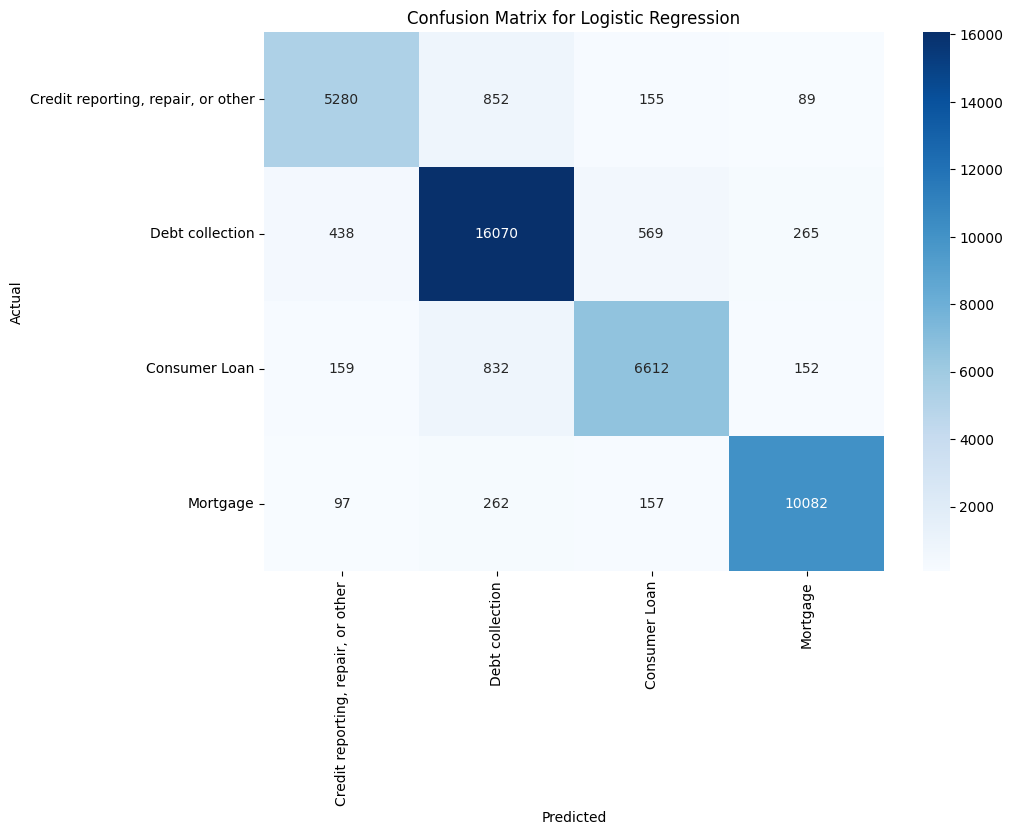

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Use the best model we found in the previous step
y_pred = best_model_pipeline.predict(X_test)

# Get the string names for the report
class_labels = [target_names[i] for i in range(4)] 

print(f"\n--- Classification Report ({best_model_name}) ---")
print(classification_report(y_test, y_pred, target_names=class_labels))

print(f"\n--- Confusion Matrix ({best_model_name}) ---")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm, 
    annot=True,        
    fmt='d',           
    cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

In [13]:
# Our best model is 'best_model' (which is pipeline_log_reg)
# Our category names are in 'target_names'

def predict_complaint(text):
    """
    Predicts the category of a single complaint text.
    
    Note: We do NOT need to call preprocess_text() manually.
    The pipeline will not work on pre-cleaned text because
    the TfidfVectorizer was trained on raw text (as per Step 3).
    
    Wait, looking back at Step 3... we trained on 'cleaned_narrative'.
    Let's correct this.
    
    CORRECTION: The way we defined the pipeline in Step 3 assumes
    we are inputting already-cleaned text.
    
    Let's redefine the prediction function to include the cleaning.
    """
    
# --- CORRECTED PREDICTION FUNCTION ---
# This function now includes the preprocessing step.

def predict_complaint_category(text):
    """
    Takes a raw text complaint, cleans it, and predicts its category.
    """
    # 1. Pre-process the text using the *same* function as in Step 2
    cleaned_text = preprocess_text(text)
    
    # 2. Use the trained pipeline to predict
    # model.predict() expects a list or iterable
    prediction_code = best_model.predict([cleaned_text])[0]
    
    # 3. Look up the category name
    return target_names[prediction_code]

# --- Example Predictions ---

complaint_1 = """
My mortgage company, XYZ Bank, charged me an incorrect fee. 
They added a $500 'inspection fee' to my escrow account 
but no inspection ever happened. I called them and they said 
it's a standard charge for all refinanced home loans.
"""

complaint_2 = """
I am being harassed by a debt collector called 'ResolveNow'. 
They call me 10 times a day, including at my workplace. 
They are trying to collect on a debt I already paid off 
five years ago. I sent them proof but they ignore it.
"""

complaint_3 = """
I checked my credit report and there is an account from a 
company I have never heard of. It says I have a delinquent
balance. This is identity theft and it has lowered my credit score.
"""

complaint_4 = """
I took out a payday loan and the interest rate is
 astronomical. I am stuck in a cycle and cannot pay it back.
"""

print("\n--- New Predictions ---")
print(f"Complaint 1 ('{complaint_1[:50]}...'):")
print(f"Prediction: {predict_complaint_category(complaint_1)}\n")

print(f"Complaint 2 ('{complaint_2[:50]}...'):")
print(f"Prediction: {predict_complaint_category(complaint_2)}\n")

print(f"Complaint 3 ('{complaint_3[:50]}...'):")
print(f"Prediction: {predict_complaint_category(complaint_3)}\n")

print(f"Complaint 4 ('{complaint_4[:50]}...'):")
print(f"Prediction: {predict_complaint_category(complaint_4)}\n")


--- New Predictions ---
Complaint 1 ('
My mortgage company, XYZ Bank, charged me an inco...'):
Prediction: Mortgage

Complaint 2 ('
I am being harassed by a debt collector called 'R...'):
Prediction: Debt collection

Complaint 3 ('
I checked my credit report and there is an accoun...'):
Prediction: Credit reporting, repair, or other

Complaint 4 ('
I took out a payday loan and the interest rate is...'):
Prediction: Consumer Loan

